In [9]:
import pandas as pd
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import string
import re
import nltk
from wordcloud import WordCloud, STOPWORDS

from datasets import Dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments
)
from peft import PeftModel
from sklearn.feature_extraction.text import CountVectorizer
from textstat import (
    flesch_reading_ease,
    flesch_kincaid_grade,
    difficult_words,
    dale_chall_readability_score
)
from tqdm.notebook import tqdm 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [10]:
# --- Configuration ---

VALIDATION_DATA_PATH = "./data/text_validation.csv"
MODEL_ARTIFACTS_PATH = "/model/lstm_model"
BASE_MODEL_NAME = "/model/lstm_model"
MAX_LENGTH = 512 
BATCH_SIZE = 16 
OUTPUT_DIR = "/output/error_analysis_output" 

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Download stopwords if not already present
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

Using device: cpu


In [11]:
# --- Load Validation Data ---
print(f"\nLoading validation data from: {VALIDATION_DATA_PATH}")
try:
    val_df = pd.read_csv(VALIDATION_DATA_PATH)
    if not {'text', 'label'}.issubset(val_df.columns):
        raise ValueError("CSV must contain 'text' and 'label' columns.")
    # Handle potential NaN/missing text
    val_df['text'] = val_df['text'].fillna('').astype(str)
    print(f"Loaded {len(val_df)} validation samples.")
    print("Label distribution:")
    print(val_df['label'].value_counts())
except FileNotFoundError:
    raise SystemExit(f"Error: Validation data file not found at {VALIDATION_DATA_PATH}")
except Exception as e:
    raise SystemExit(f"Error loading validation data: {e}")


Loading validation data from: ./data/text_validation.csv
Loaded 16000 validation samples.
Label distribution:
label
1    8082
0    7918
Name: count, dtype: int64


In [ ]:
import pandas as pd
from keras.models import load_model
from keras.preprocessing.text import tokenizer_from_json
from keras.utils import pad_sequences
import numpy as np
import json
import os
from data_preprocessing import extract_linguistic_features, minmax_scale_features

VALIDATION_DATA_PATH = "./data/text_validation.csv"
BATCH_SIZE = 16
OUTPUT_DIR = "./output/error_analysis_output"
features_addition = False

val_df = pd.read_csv(VALIDATION_DATA_PATH)

if features_addition:
    print("Linguistic features extraction is enabled.")
    model = load_model("./model/lstm_model_with_features")
else:
    print("Linguistic features extraction is disabled.")
    model = load_model("./model/lstm_model_no_features")
    
with open("./model/tokenizer.json") as f:
    tokenizer_json = f.read()
tokenizer = tokenizer_from_json(tokenizer_json)

print("Model input structure:", model.input)
if features_addition:
    max_length_from_model = model.input[0].shape[1]
else:
    try:
        max_length_from_model = model.input.shape[1]
    except AttributeError:
        raise ValueError("Model input shape is not accessible. Check the loaded model structure.")
    print(f"Model expects input of shape: {max_length_from_model}")

val_sequences = tokenizer.texts_to_sequences(val_df['text'])
val_padded = pad_sequences(val_sequences, maxlen=max_length_from_model, padding='post', truncating='post')


if features_addition:
    print("Linguistic features extraction is enabled.")
    
    features = val_df['text'].apply(extract_linguistic_features)
    features_df = pd.DataFrame(features.tolist())
    
    print("Linguistic features extracted:")
    print(features_df.head())
    
    scaled_features_df = minmax_scale_features(features_df)
    print("Features scaled using Min-Max scaling:")
    print(scaled_features_df.head())
    
    linguistic_features = scaled_features_df.values
else:
    print("Linguistic features extraction is disabled.")
    linguistic_features = None

if features_addition:
    predicted_probabilities = model.predict(
        [val_padded, linguistic_features], 
        batch_size=BATCH_SIZE
    )
else:
    predicted_probabilities = model.predict(val_padded, batch_size=BATCH_SIZE)

predicted_labels = (predicted_probabilities > 0.5).astype(int).flatten()

val_df['prediction'] = predicted_labels
val_df['pred_probability'] = predicted_probabilities.flatten()
val_df['is_correct'] = (val_df['label'] == val_df['prediction'])

os.makedirs(OUTPUT_DIR, exist_ok=True)
output_path = os.path.join(OUTPUT_DIR, "validation_predictions.csv")
val_df.to_csv(output_path, index=False)

print(f"Validation results saved to {output_path}")

Model input structure: KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name='word_level_input'), name='word_level_input', description="created by layer 'word_level_input'")
Model expects input of shape: 100
Linguistic features extraction is disabled.
1000/1000 [==============================] - 21s 19ms/step
Validation results saved to ./output/error_analysis_output\validation_predictions.csv


In [13]:
# --- Combine Data & Predictions ---
print("\nCombining predictions with original data...")
val_df['prediction'] = predicted_labels
val_df['pred_probability'] = predicted_probabilities
val_df['is_correct'] = (val_df['label'] == val_df['prediction'])

# Identify TP, TN, FP, FN
val_df['result_type'] = 'NA'
val_df.loc[(val_df['is_correct'] == True) & (val_df['label'] == 0), 'result_type'] = 'TN' 
val_df.loc[(val_df['is_correct'] == True) & (val_df['label'] == 1), 'result_type'] = 'TP'
val_df.loc[(val_df['is_correct'] == False) & (val_df['label'] == 0), 'result_type'] = 'FP'
val_df.loc[(val_df['is_correct'] == False) & (val_df['label'] == 1), 'result_type'] = 'FN'

print("Prediction results combined. Counts:")
print(val_df['result_type'].value_counts())

# Separate correct and incorrect predictions
correct_df = val_df[val_df['is_correct']].copy()
incorrect_df = val_df[~val_df['is_correct']].copy()
tp_df = val_df[val_df['result_type'] == 'TP'].copy()
tn_df = val_df[val_df['result_type'] == 'TN'].copy()
fp_df = val_df[val_df['result_type'] == 'FP'].copy()
fn_df = val_df[val_df['result_type'] == 'FN'].copy()

if len(incorrect_df) == 0:
    print("\n No misclassifications found on the validation set! Error analysis ends here.")



Combining predictions with original data...
Prediction results combined. Counts:
result_type
TP    6586
TN    6469
FN    1496
FP    1449
Name: count, dtype: int64



--- Analyzing Text Length ---

Descriptive Statistics for Text Length:
Correct Predictions:
 count    13055.000000
mean      2129.918422
std       2649.777993
min          5.000000
25%        875.000000
50%        969.000000
75%       3037.000000
max      41001.000000
Name: text_length, dtype: float64

Incorrect Predictions:
 count     2945.000000
mean      2664.867572
std       3141.225419
min         38.000000
25%        820.000000
50%       2009.000000
75%       4046.000000
max      48723.000000
Name: text_length, dtype: float64


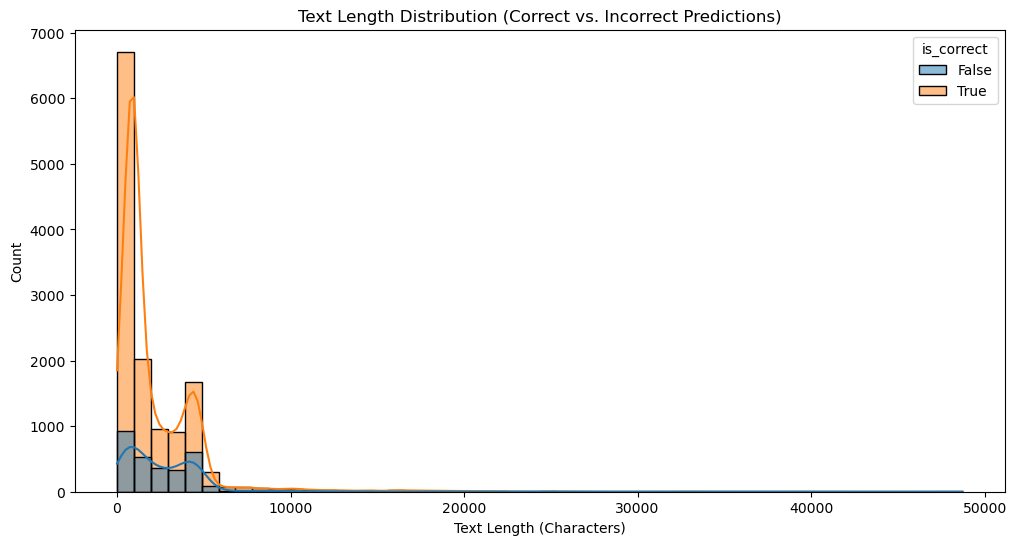

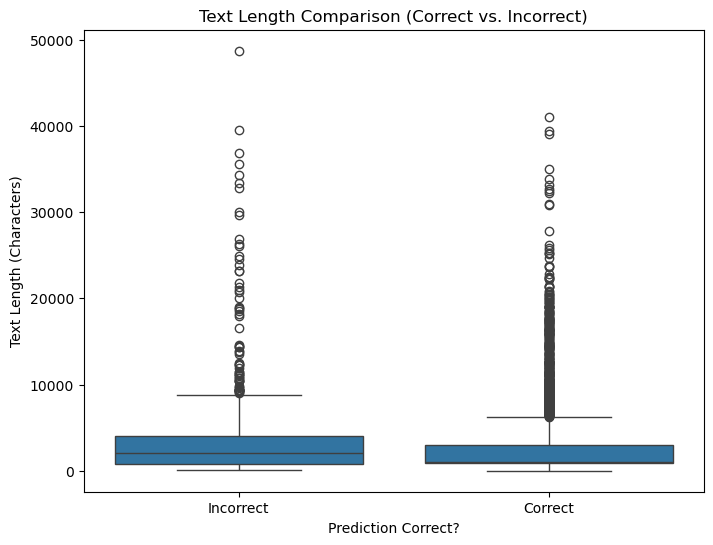

In [14]:
# --- Error Analysis ---

## 1 Text Length Analysis
print("\n--- Analyzing Text Length ---")
val_df['text_length'] = val_df['text'].apply(len)
correct_df['text_length'] = correct_df['text'].apply(len)
incorrect_df['text_length'] = incorrect_df['text'].apply(len)

print("\nDescriptive Statistics for Text Length:")
print("Correct Predictions:\n", correct_df['text_length'].describe())
print("\nIncorrect Predictions:\n", incorrect_df['text_length'].describe())

plt.figure(figsize=(12, 6))
sns.histplot(data=val_df, x='text_length', hue='is_correct', kde=True, bins=50)
plt.title('Text Length Distribution (Correct vs. Incorrect Predictions)')
plt.xlabel('Text Length (Characters)')
plt.ylabel('Count')
plt.savefig(os.path.join(OUTPUT_DIR, "length_histogram.png"))
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(data=val_df, x='is_correct', y='text_length')
plt.title('Text Length Comparison (Correct vs. Incorrect)')
plt.xlabel('Prediction Correct?')
plt.ylabel('Text Length (Characters)')
plt.xticks([False, True], ['Incorrect', 'Correct'])
plt.savefig(os.path.join(OUTPUT_DIR, "length_boxplot.png"))
plt.show()


--- Analyzing Text Length by Result Type (TP, TN, FP, FN) ---

--- Analyzing Text Length ---

Descriptive Statistics for Text Length:
TN Predictions:
 count     6469.000000
mean      2257.740764
std       3379.730256
min        262.000000
25%        913.000000
50%        952.000000
75%       1806.000000
max      41001.000000
Name: text_length, dtype: float64

FP Predictions:
 count     1449.000000
mean      2736.346446
std       4211.281675
min         38.000000
25%        421.000000
50%       1458.000000
75%       3847.000000
max      48723.000000
Name: text_length, dtype: float64

TP Predictions:
 count    6586.000000
mean     2004.366839
std      1633.254449
min         5.000000
25%       511.000000
50%      1462.500000
75%      3563.500000
max      5832.000000
Name: text_length, dtype: float64

FN Predictions:
 count    1496.000000
mean     2595.634358
std      1497.963666
min       352.000000
25%      1191.750000
50%      2458.500000
75%      4121.250000
max      5399.000000
Name

C:\Users\laihu\AppData\Local\Temp\ipykernel_420\4212249442.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Result Type')


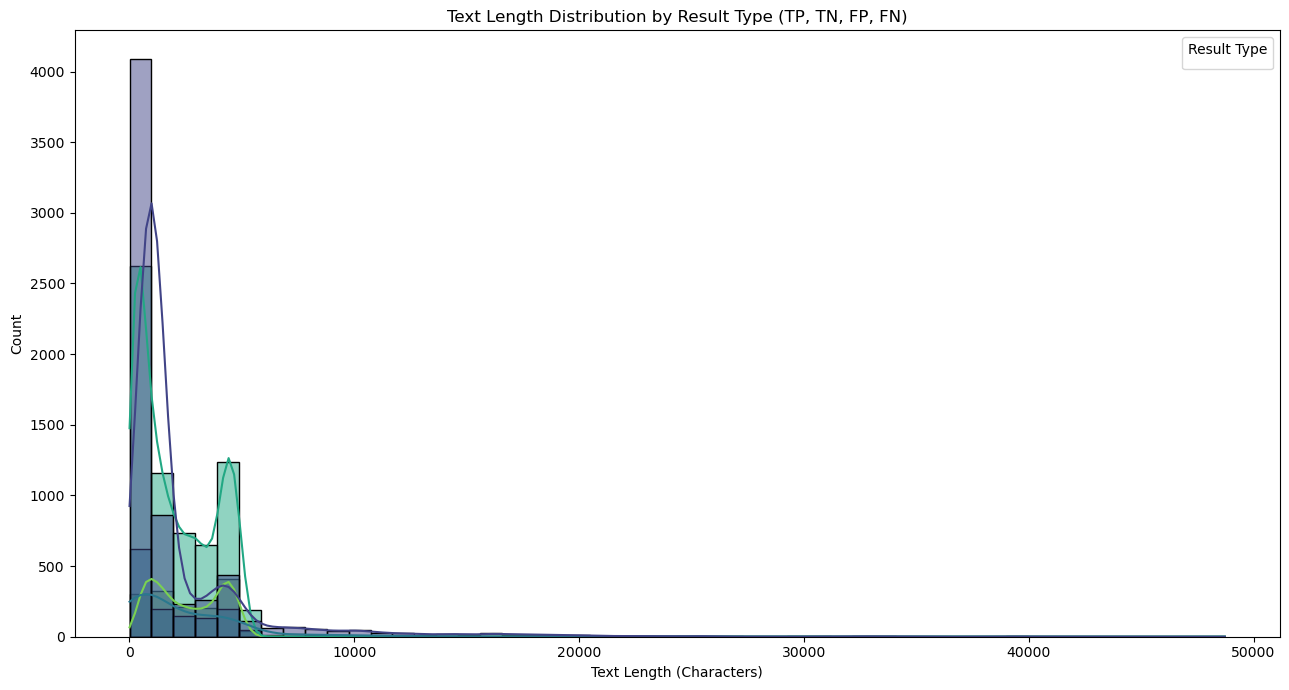

Generating boxplot by result type...


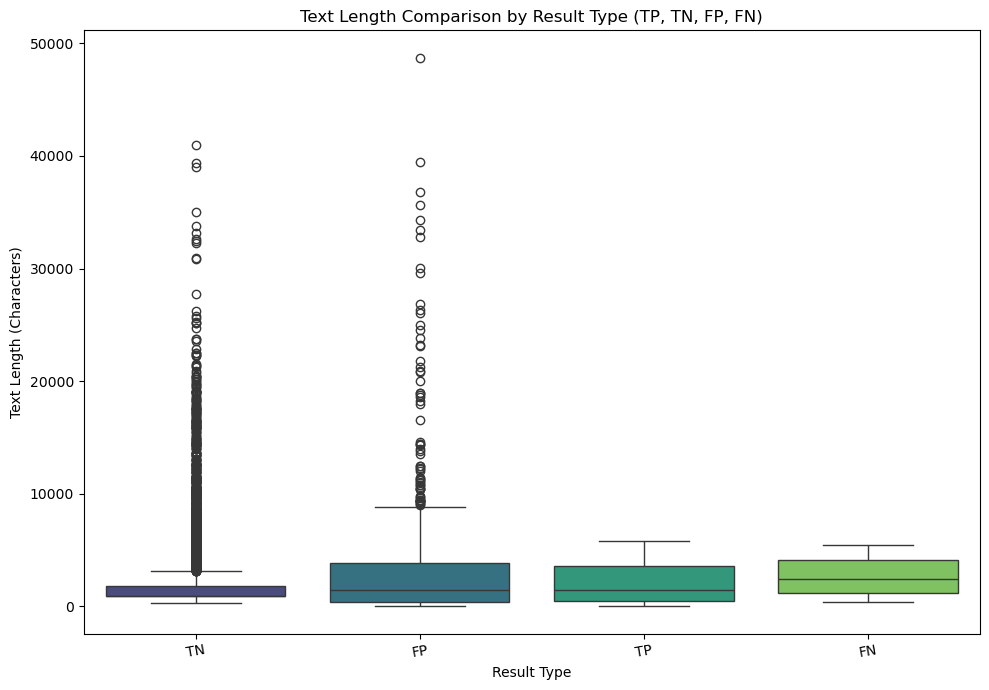

In [15]:
# --- Text Length Analysis by Result Type (TP, TN, FP, FN) ---
print("\n--- Analyzing Text Length by Result Type (TP, TN, FP, FN) ---")

## 1 Text Length Analysis
print("\n--- Analyzing Text Length ---")
tn_df['text_length'] = tn_df['text'].apply(len)
fp_df['text_length'] = fp_df['text'].apply(len)
tp_df['text_length'] = tp_df['text'].apply(len)
fn_df['text_length'] = fn_df['text'].apply(len)

print("\nDescriptive Statistics for Text Length:")
print("TN Predictions:\n", tn_df['text_length'].describe())
print("\nFP Predictions:\n", fp_df['text_length'].describe())
print("\nTP Predictions:\n", tp_df['text_length'].describe())
print("\nFN Predictions:\n", fn_df['text_length'].describe())

# Define the desired order for plot categories
type_order = ['TN', 'FP', 'TP', 'FN']

plot_data = val_df[val_df['result_type'].isin(type_order) & val_df['text_length'].notna()].copy()

if plot_data.empty:
    print("No data found for TP/TN/FP/FN categories. Skipping plots.")
else:
    # 1. Histogram by Result Type
    print("Generating histogram by result type...")
    plt.figure(figsize=(13, 7))
    sns.histplot(data=plot_data, x='text_length', hue='result_type', kde=True, bins=50,
                 hue_order=type_order, palette='viridis')
    plt.title('Text Length Distribution by Result Type (TP, TN, FP, FN)')
    plt.xlabel('Text Length (Characters)')
    plt.ylabel('Count')
    plt.legend(title='Result Type')
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "length_histogram_by_type.png"))
    plt.show()

    # 2. Box Plot by Result Type
    print("Generating boxplot by result type...")
    plt.figure(figsize=(10, 7))
    sns.boxplot(data=plot_data, x='result_type', y='text_length',
                order=type_order, palette='viridis')
    plt.title('Text Length Comparison by Result Type (TP, TN, FP, FN)')
    plt.xlabel('Result Type')
    plt.ylabel('Text Length (Characters)')
    plt.xticks(rotation=10) 
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "length_boxplot_by_type.png"))
    plt.show()



--- Analyzing Text Complexity ---


Calculating Complexity:   0%|          | 0/16000 [00:00<?, ?it/s]


Average Complexity Scores:
            difficult_words
is_correct                 
False       78.562649
True        62.442512


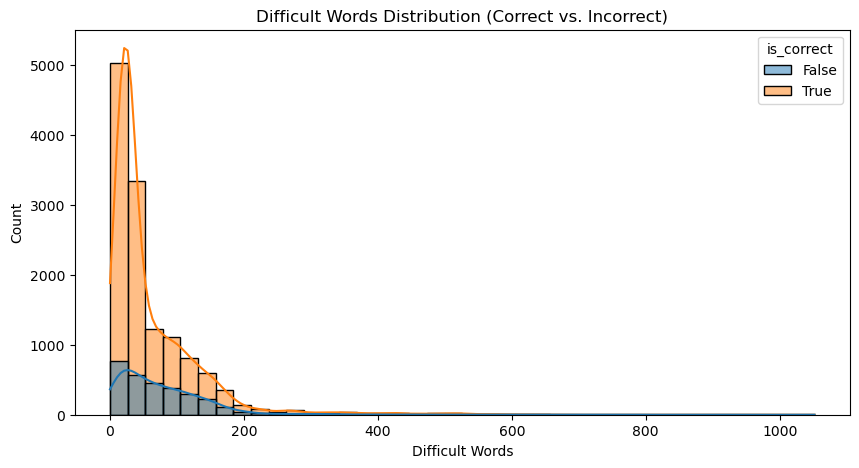

In [16]:
## 2 Text Complexity Analysis 
print("\n--- Analyzing Text Complexity ---")

# Function to calculate all scores
def calculate_complexity(text):
    try:
        return pd.Series({
            'flesch_ease': flesch_reading_ease(text),
            'flesch_kincaid': flesch_kincaid_grade(text),
            'difficult_words': difficult_words(text),
            'dale_chall': dale_chall_readability_score(text)
        })
    except Exception:
        return pd.Series({
            'flesch_ease': np.nan, 'flesch_kincaid': np.nan,
            'difficult_words': np.nan, 'dale_chall': np.nan
        })

# Apply complexity calculations
tqdm.pandas(desc="Calculating Complexity")
complexity_scores = val_df['text'].progress_apply(calculate_complexity)
val_df = pd.concat([val_df, complexity_scores], axis=1)

# Compare average scores
print("\nAverage Complexity Scores:")
print(val_df.groupby('is_correct')[['difficult_words']].mean())

# Plot distributions
complexity_metrics = ['difficult_words']
for metric in complexity_metrics:
    plt.figure(figsize=(10, 5))
    sns.histplot(data=val_df, x=metric, hue='is_correct', kde=True, bins=40)
    plt.title(f'{metric.replace("_", " ").title()} Distribution (Correct vs. Incorrect)')
    plt.xlabel(metric.replace("_", " ").title())
    plt.ylabel('Count')
    plt.savefig(os.path.join(OUTPUT_DIR, f"complexity_{metric}_hist.png"))
    plt.show()


--- Analyzing Text Complexity by Four Result Types (TN, FP, TP, FN) ---
Shape before duplicate removal: (16000, 11)
Shape after duplicate removal: (16000, 11)
Columns after duplicate removal: Index(['text', 'label', 'prediction', 'pred_probability', 'is_correct',
       'result_type', 'text_length', 'flesch_ease', 'flesch_kincaid',
       'difficult_words', 'dale_chall'],
      dtype='object')

Descriptive Statistics for Complexity Metrics by Result Type:

--- Flesch Ease ---
              count        mean         std      min      25%      50%  \
result_type                                                              
TN           6469.0 -310.191350  550.263242 -6793.32 -255.700  -94.310   
FP           1449.0 -391.471560  694.153983 -7910.16 -580.160 -182.960   
TP           6586.0 -286.812650  297.801970 -2139.64 -566.885 -189.215   
FN           1496.0 -396.654365  274.922713  -847.10 -697.560 -367.010   

                  75%     max  
result_type                    
TN       

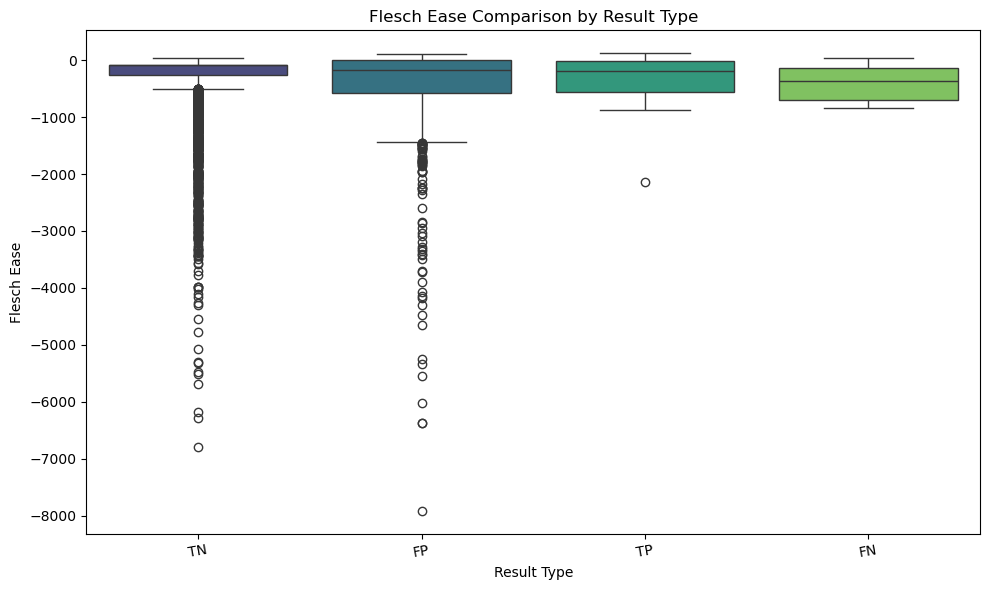

Could not generate legend for flesch_ease histogram.


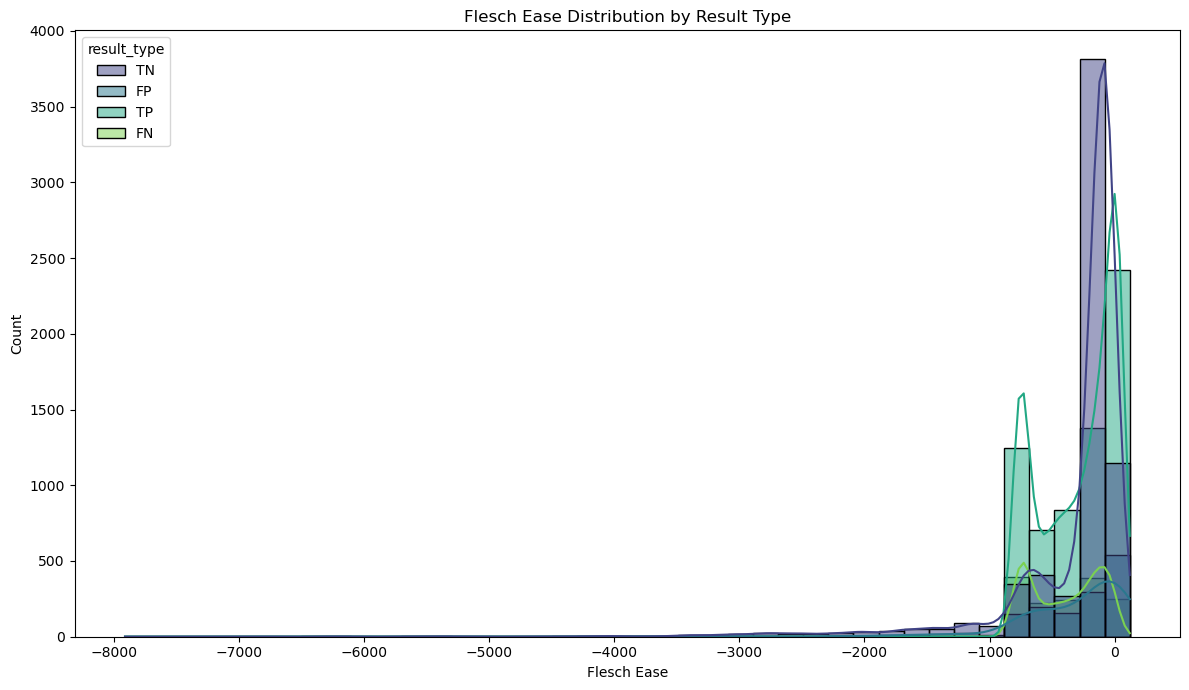

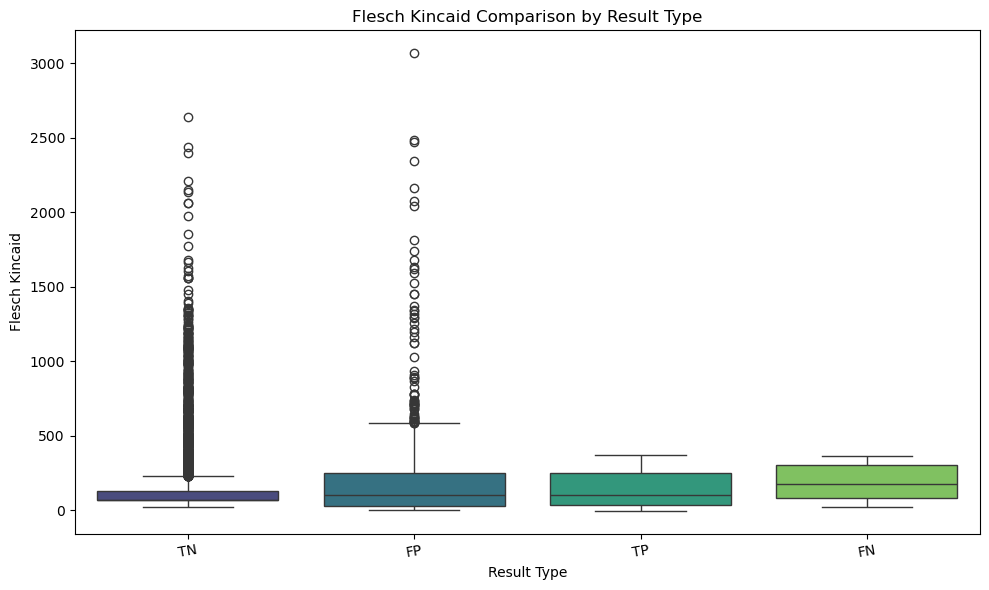

Could not generate legend for flesch_kincaid histogram.


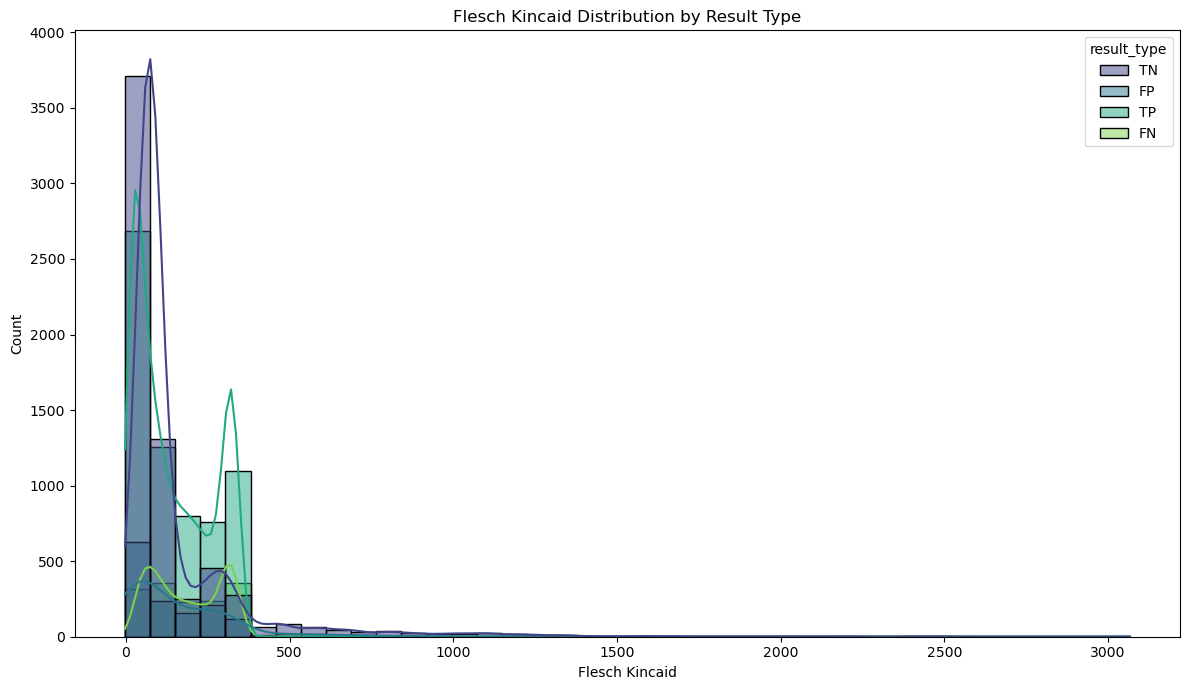

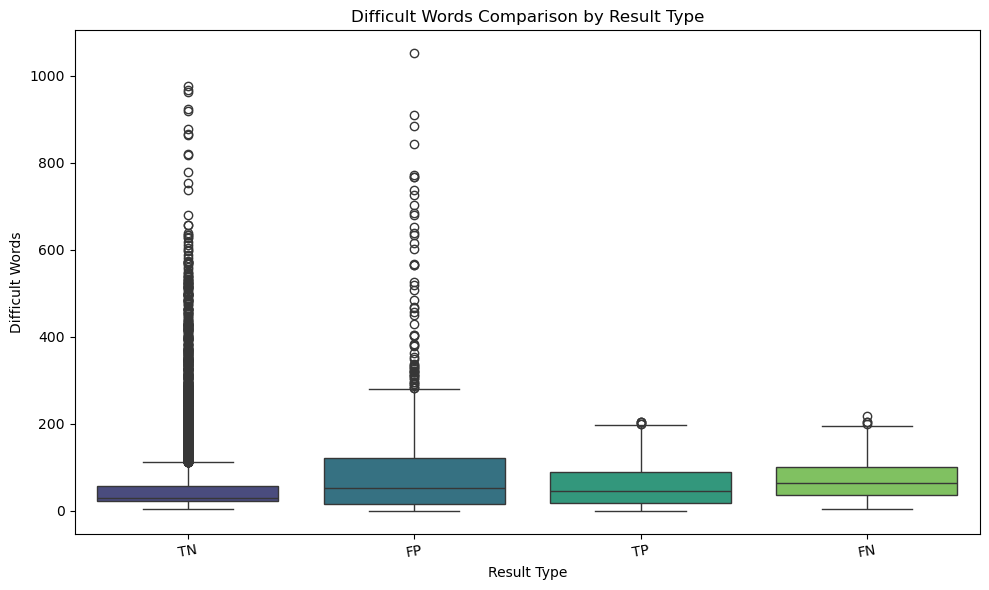

Could not generate legend for difficult_words histogram.


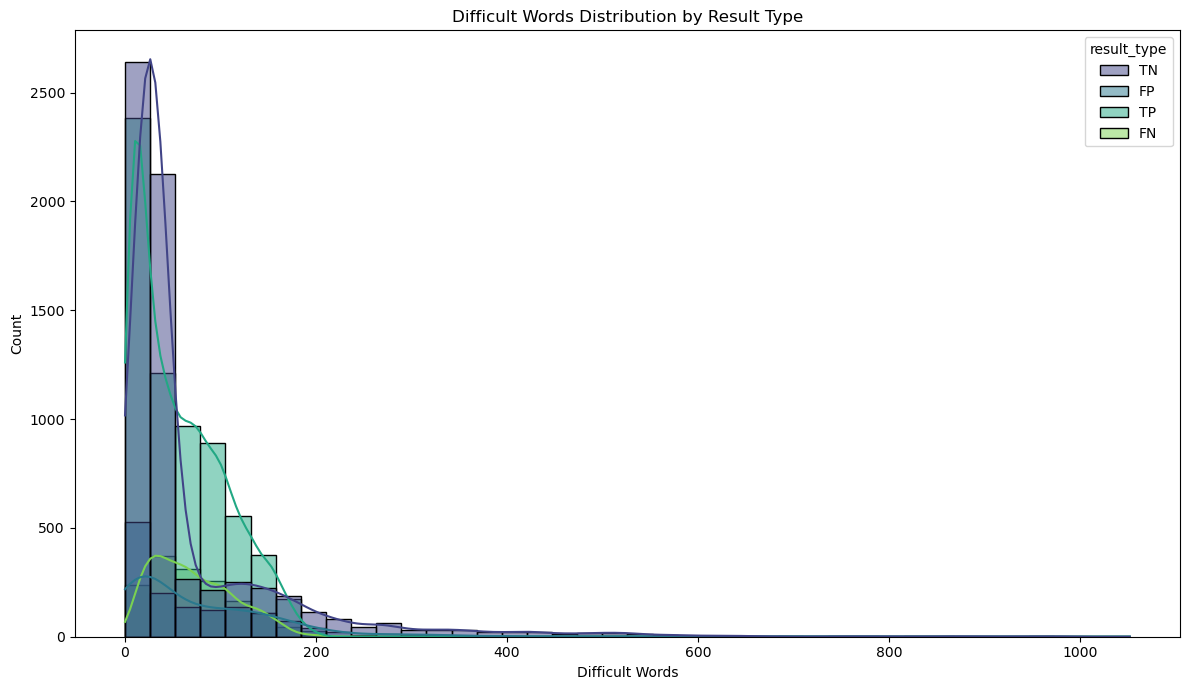

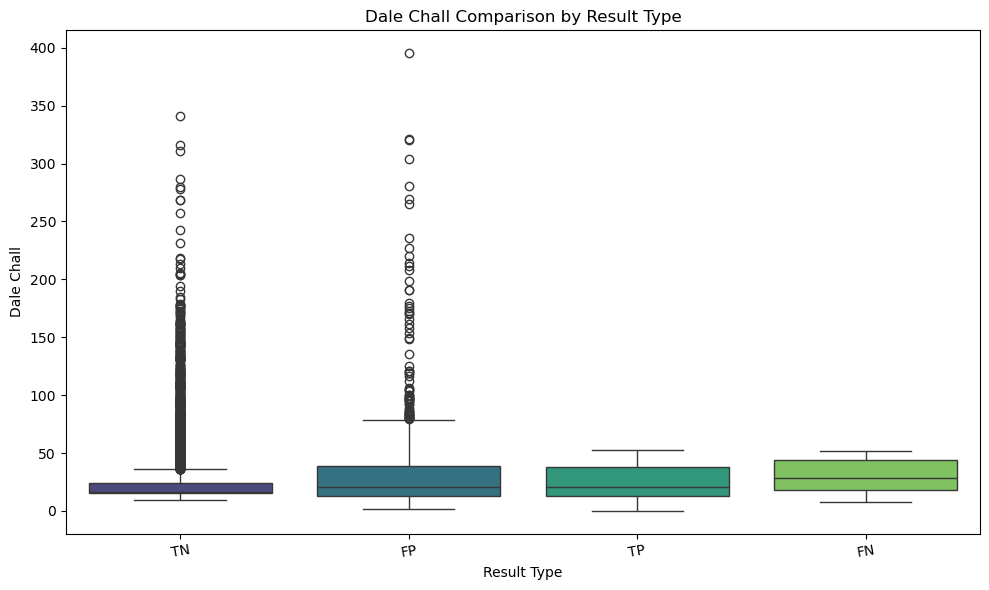

Could not generate legend for dale_chall histogram.


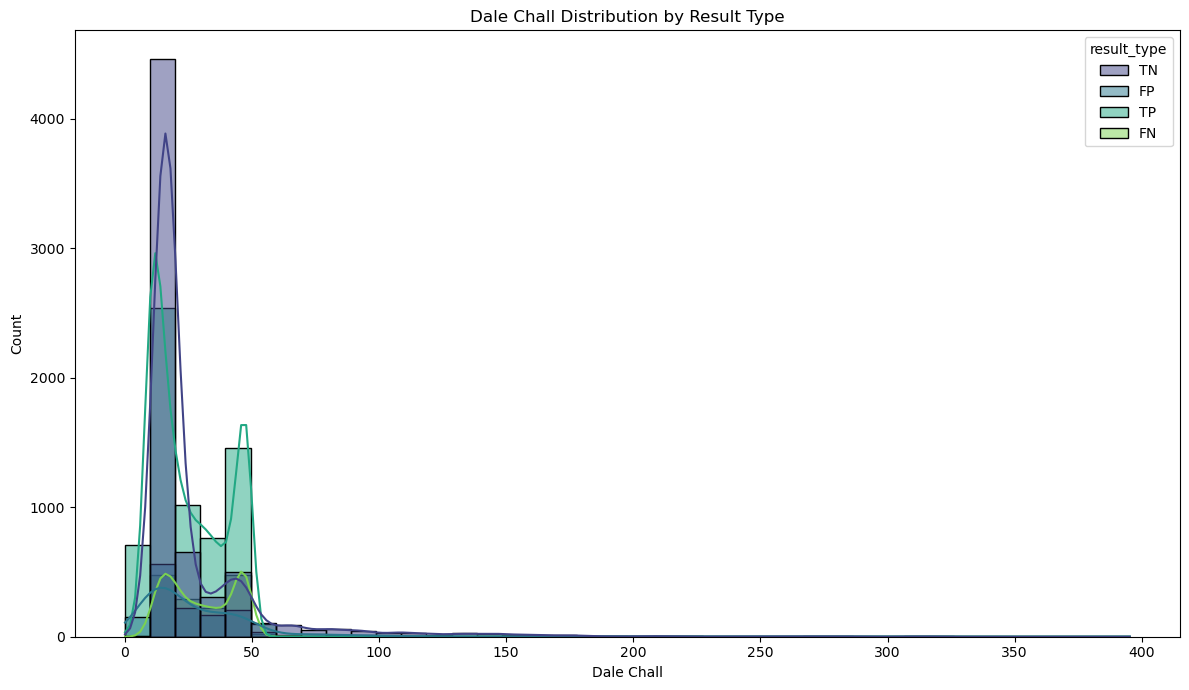

In [17]:
print("\n--- Analyzing Text Complexity by Four Result Types (TN, FP, TP, FN) ---")

type_order = ['TN', 'FP', 'TP', 'FN']
print("Shape before duplicate removal:", val_df.shape)
val_df = val_df.loc[:, ~val_df.columns.duplicated(keep='first')]
print("Shape after duplicate removal:", val_df.shape)
print("Columns after duplicate removal:", val_df.columns)

plot_data_four_types = val_df[val_df['result_type'].isin(type_order)].copy()

print("\nDescriptive Statistics for Complexity Metrics by Result Type:")
for metric in complexity_metrics:
    if metric in plot_data_four_types.columns:
        print(f"\n--- {metric.replace('_', ' ').title()} ---")
        stats = plot_data_four_types.groupby('result_type')[metric].describe()
        try:
            print(stats.reindex(type_order))
        except KeyError:
            print("Warning: Not all result types found in data for stats ordering.")
            print(stats) 
    else:
        print(f"Metric '{metric}' not found for descriptive stats.")


print("\nGenerating complexity plots by four result types (TN, FP, TP, FN)...")
for metric in complexity_metrics:
    if metric in plot_data_four_types and pd.api.types.is_numeric_dtype(plot_data_four_types[metric]):
       
        plot_data_metric = plot_data_four_types.dropna(subset=[metric, 'result_type'])

        if not plot_data_metric.empty:
            # 1. Box Plot
            plt.figure(figsize=(10, 6))
            sns.boxplot(data=plot_data_metric, x='result_type', y=metric, order=type_order, palette='viridis')
            plt.title(f'{metric.replace("_", " ").title()} Comparison by Result Type')
            plt.xlabel('Result Type')
            plt.ylabel(metric.replace("_", " ").title())
            plt.xticks(rotation=10)
            plt.tight_layout()
            plt.savefig(os.path.join(OUTPUT_DIR, f"complexity_{metric}_boxplot_four_types.png"))
            plt.show()

            # 2. Histogram 
            plt.figure(figsize=(12, 7))
            # Use histplot with hue
            ax = sns.histplot(data=plot_data_metric, x=metric, hue='result_type',
                              hue_order=type_order, kde=True, bins=40, palette='viridis',
                              common_norm=False) 
            plt.title(f'{metric.replace("_", " ").title()} Distribution by Result Type')
            plt.xlabel(metric.replace("_", " ").title())
            plt.ylabel('Count')

            handles, labels = ax.get_legend_handles_labels()
            if handles and labels:
                 ax.legend(handles=handles, labels=labels, title='Result Type', bbox_to_anchor=(1.02, 1), loc='upper left')
                 plt.subplots_adjust(right=0.85) 
            else:
                 print(f"Could not generate legend for {metric} histogram.")
                 plt.tight_layout() 

            plt.savefig(os.path.join(OUTPUT_DIR, f"complexity_{metric}_hist_four_types.png"))
            plt.show()
        else:
            print(f"No valid data to plot for {metric} across four types after dropping NaNs.")
    else:
        print(f"Skipping plots for {metric} as column is missing or not numeric in filtered data.")



--- Analyzing Top Keywords ---

Top 20 Keywords for Correct Predictions:
      Keyword  Frequency
0        said      12047
1      people      11156
2         new      10444
3        time       8774
4        like       8352
5        just       8091
6        make       6351
7         way       5443
8         use       5188
9        know       4989
10      world       4873
11      years       4674
12       good       4404
13       work       4325
14       dont       4282
15       want       4190
16      going       4146
17       need       4086
18      think       4019
19  different       3874


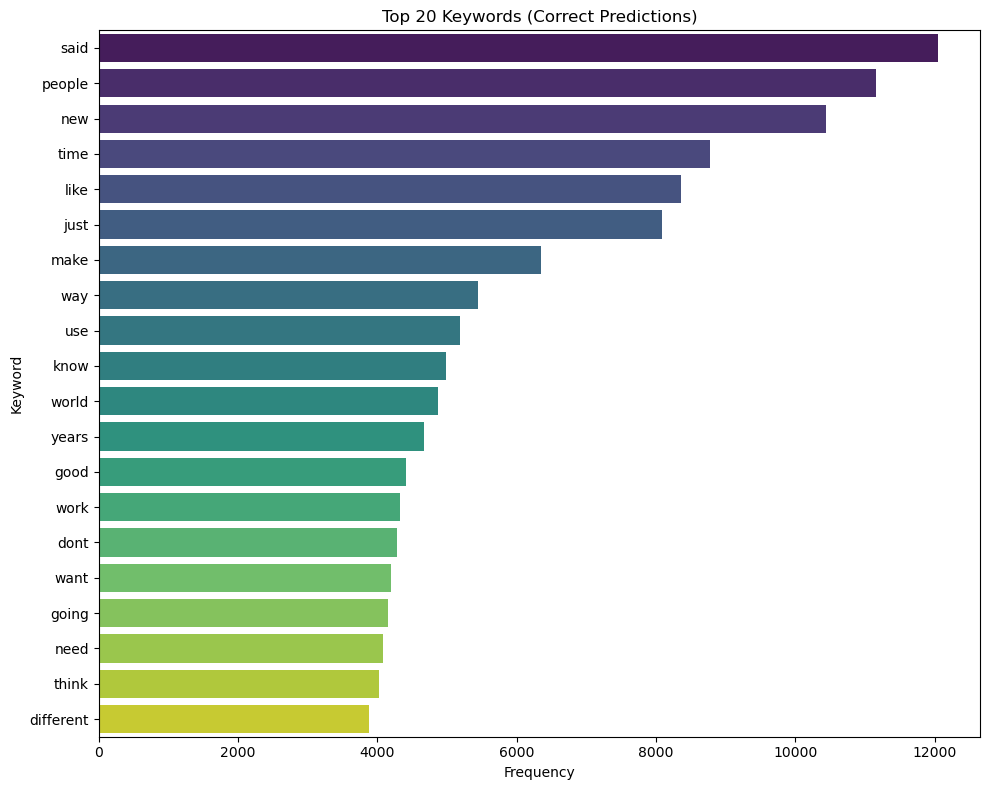


Top 20 Keywords for Incorrect Predictions:
   Keyword  Frequency
0     said       3410
1   people       3113
2      new       2759
3     time       2448
4     just       2245
5     like       2228
6     make       1765
7      use       1689
8      way       1428
9    years       1383
10   world       1297
11    know       1228
12    used       1217
13    dont       1207
14    work       1122
15    want       1118
16    year       1110
17    need       1106
18    good       1102
19   going       1100


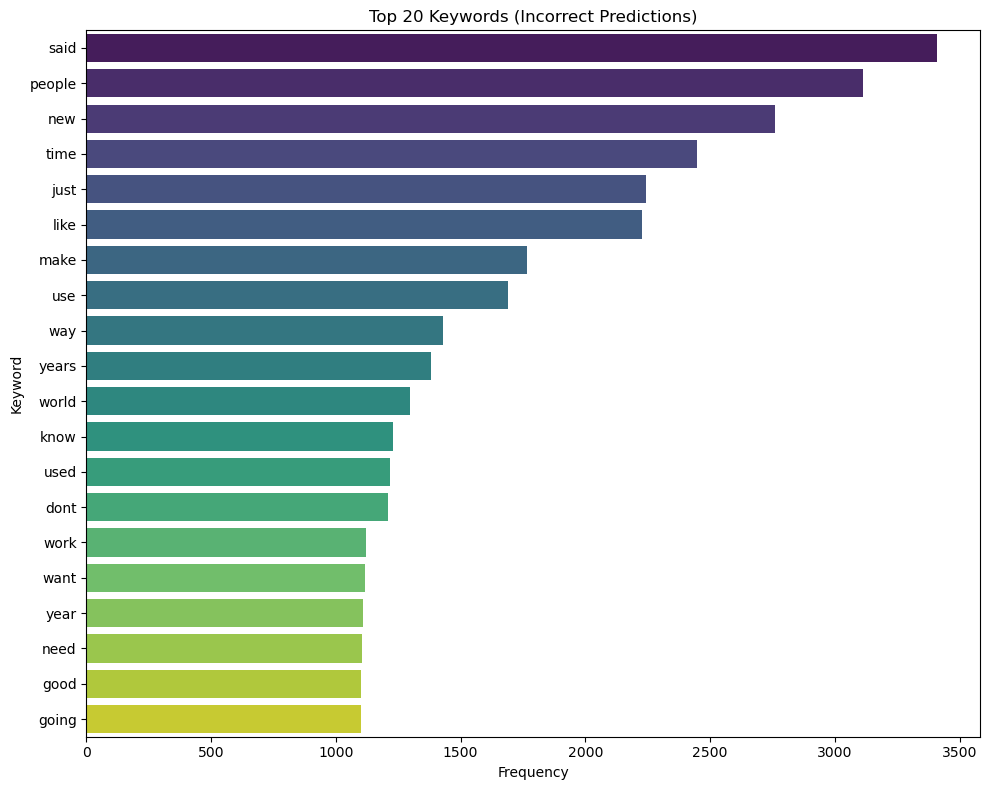

In [18]:
## 3 Keyword Analysis 
print("\n--- Analyzing Top Keywords ---")

def plot_top_keywords(df, text_column, title_suffix, num_keywords=20, filename_suffix=""):
    if len(df) == 0:
        print(f"Skipping keyword analysis for '{title_suffix}': No samples.")
        return

    print(f"\nTop {num_keywords} Keywords for {title_suffix}:")
    try:
        vec = CountVectorizer(stop_words='english', max_features=num_keywords).fit(df[text_column])
        bag_of_words = vec.transform(df[text_column])
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

        top_df = pd.DataFrame(words_freq[:num_keywords], columns=['Keyword', 'Frequency'])
        print(top_df)

        plt.figure(figsize=(10, 8))
        sns.barplot(x='Frequency', y='Keyword', data=top_df, palette='viridis')
        plt.title(f'Top {num_keywords} Keywords ({title_suffix})')
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, f"keywords_{filename_suffix}.png"))
        plt.show()

    except ValueError as e:
        print(f"Could not generate keywords for {title_suffix}: {e}") 

# Compare Correct vs Incorrect
plot_top_keywords(correct_df, 'text', 'Correct Predictions', filename_suffix="correct")
plot_top_keywords(incorrect_df, 'text', 'Incorrect Predictions', filename_suffix="incorrect")

# analyze FP and FN separately
# plot_top_keywords(fp_df, 'text', 'False Positives (Human -> AI)', filename_suffix="fp")
# plot_top_keywords(fn_df, 'text', 'False Negatives (AI -> Human)', filename_suffix="fn")



Top 20 Keywords for True Negatives (Human):
      Keyword  Frequency
0      people       4815
1        time       4523
2        like       4299
3        just       4055
4         new       3492
5        said       3328
6       world       2659
7         way       2582
8        life       2454
9        know       2423
10    company       2392
11        use       2257
12       work       2235
13       make       2201
14      years       2183
15  different       2054
16        man       2013
17        did       2010
18       used       1961
19       good       1829


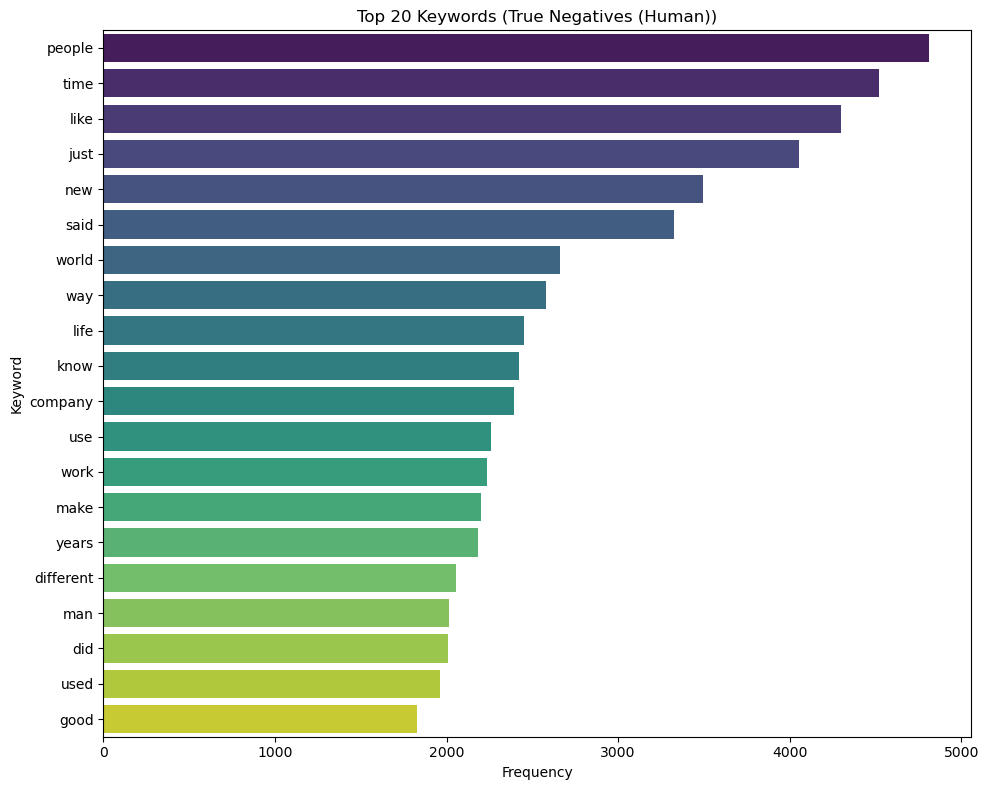


Top 20 Keywords for False Positives (Human -> AI):
        Keyword  Frequency
0        people       1474
1          said       1252
2           new       1180
3          time       1038
4           use        840
5          like        839
6       company        727
7          just        721
8          make        670
9          used        649
10        world        615
11          way        586
12        years        559
13  information        549
14        women        548
15       health        547
16   government        536
17         work        535
18     business        528
19        state        516


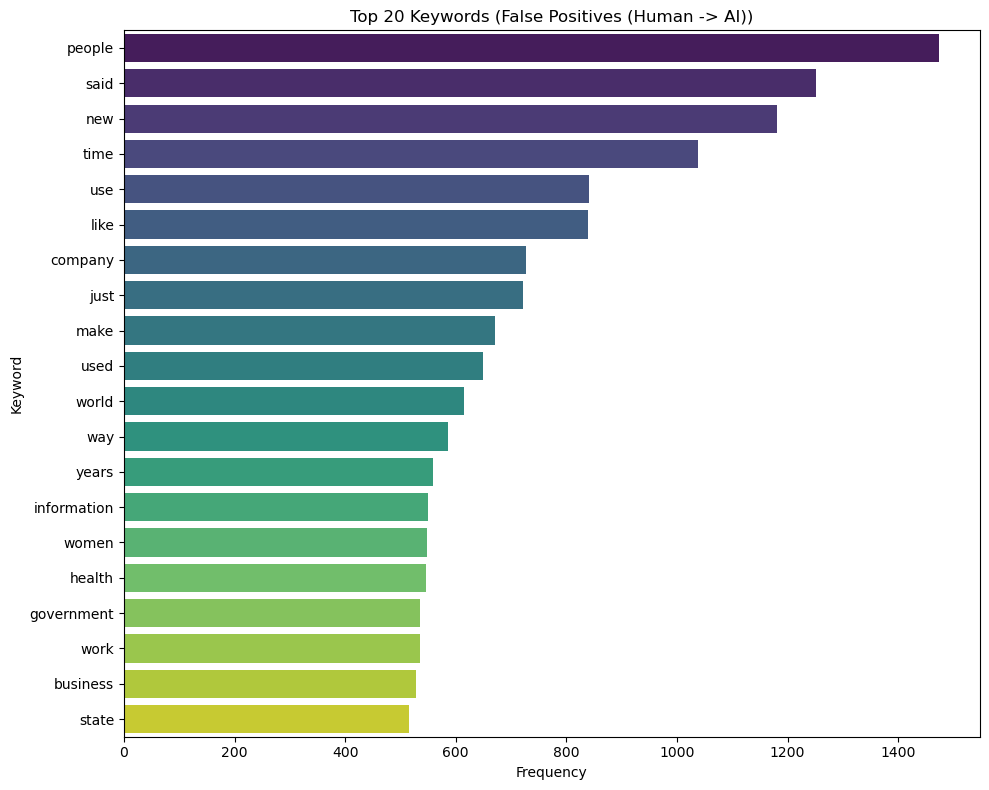


Top 20 Keywords for False Negatives (AI -> Human):
   Keyword  Frequency
0     said       2158
1   people       1639
2      new       1579
3     just       1524
4     time       1410
5     like       1389
6     make       1095
7     dont        896
8     know        875
9      use        849
10     way        842
11   years        824
12   going        803
13    want        799
14   think        708
15    good        692
16      im        688
17   world        682
18    game        636
19    need        632


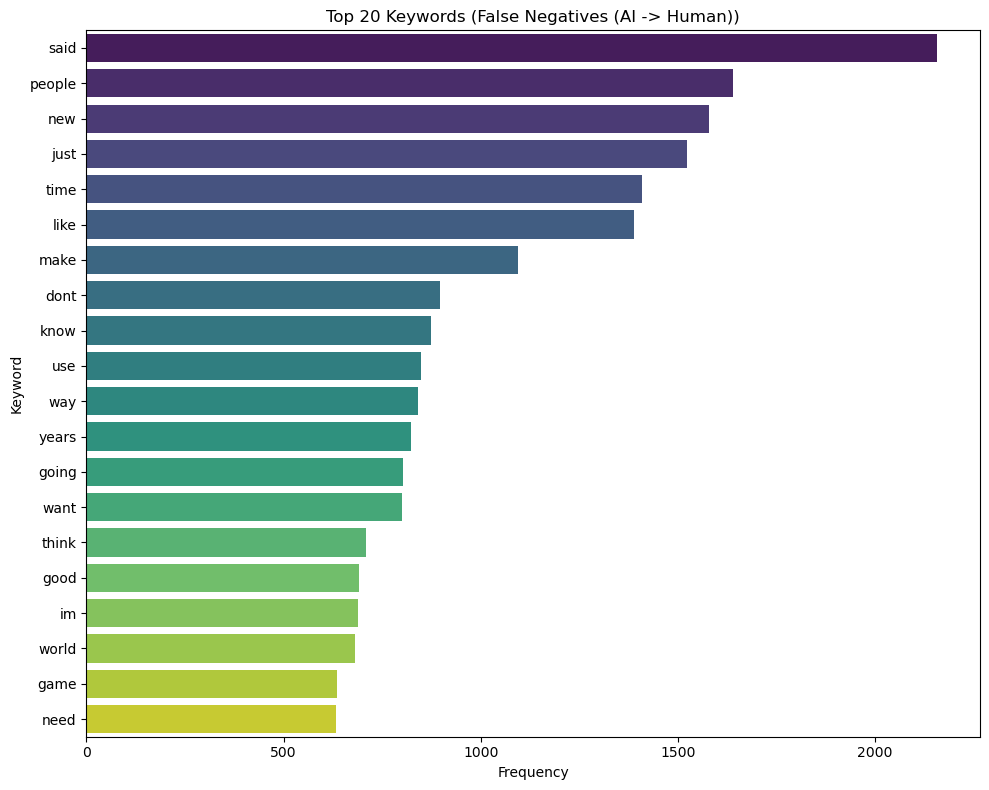


Top 20 Keywords for True Positives (AI):
       Keyword  Frequency
0         said       8719
1          new       6952
2       people       6341
3         time       4251
4         make       4150
5         like       4053
6         just       4036
7         want       2976
8          use       2931
9          way       2861
10       going       2712
11        dont       2631
12       think       2576
13        good       2575
14        know       2566
15        year       2532
16  government       2518
17       years       2491
18        game       2454
19        need       2396


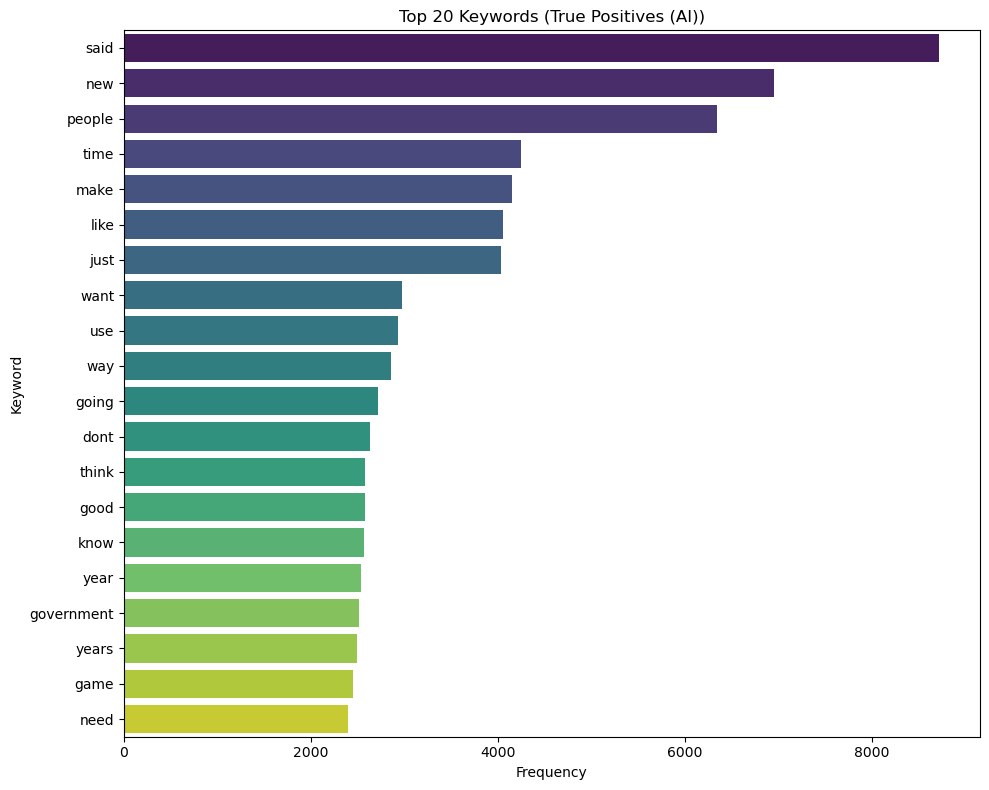

In [19]:
plot_top_keywords(tn_df, 'text', 'True Negatives (Human)', filename_suffix="tn")
plot_top_keywords(fp_df, 'text', 'False Positives (Human -> AI)', filename_suffix="fp")
plot_top_keywords(fn_df, 'text', 'False Negatives (AI -> Human)', filename_suffix="fn")
plot_top_keywords(tp_df, 'text', 'True Positives (AI)', filename_suffix="tp")


--- Analyzing N-grams ---

-- Top 2-grams --

Top 2-grams for Correct Predictions:
      2-gram  Frequency
0     of the      33528
1     in the      27782
2     to the      14435
3     on the      11370
4    and the       9078
5      to be       8751
6    for the       8419
7   that the       8008
8      it is       6943
9       in a       6929
10  with the       6713
11    at the       6454
12      is a       6209
13  from the       5979
14      of a       5749
15    it was       5186
16      as a       5150
17    by the       4963
18    is the       4157
19    with a       4031


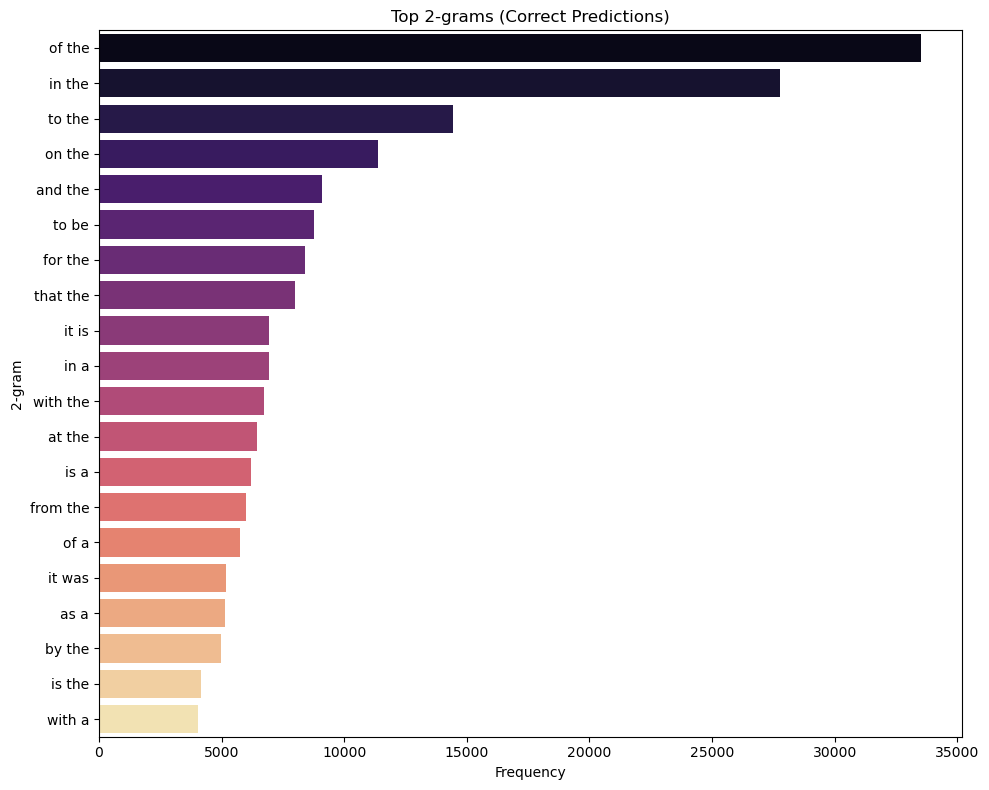


Top 2-grams for Incorrect Predictions:
      2-gram  Frequency
0     of the       9921
1     in the       8269
2     to the       4061
3     on the       3097
4    and the       2620
5      to be       2529
6    for the       2480
7   that the       2185
8       in a       1974
9   with the       1963
10     it is       1962
11      is a       1876
12    at the       1841
13  from the       1658
14    by the       1584
15      as a       1493
16      of a       1474
17   will be       1329
18    is the       1324
19   this is       1196


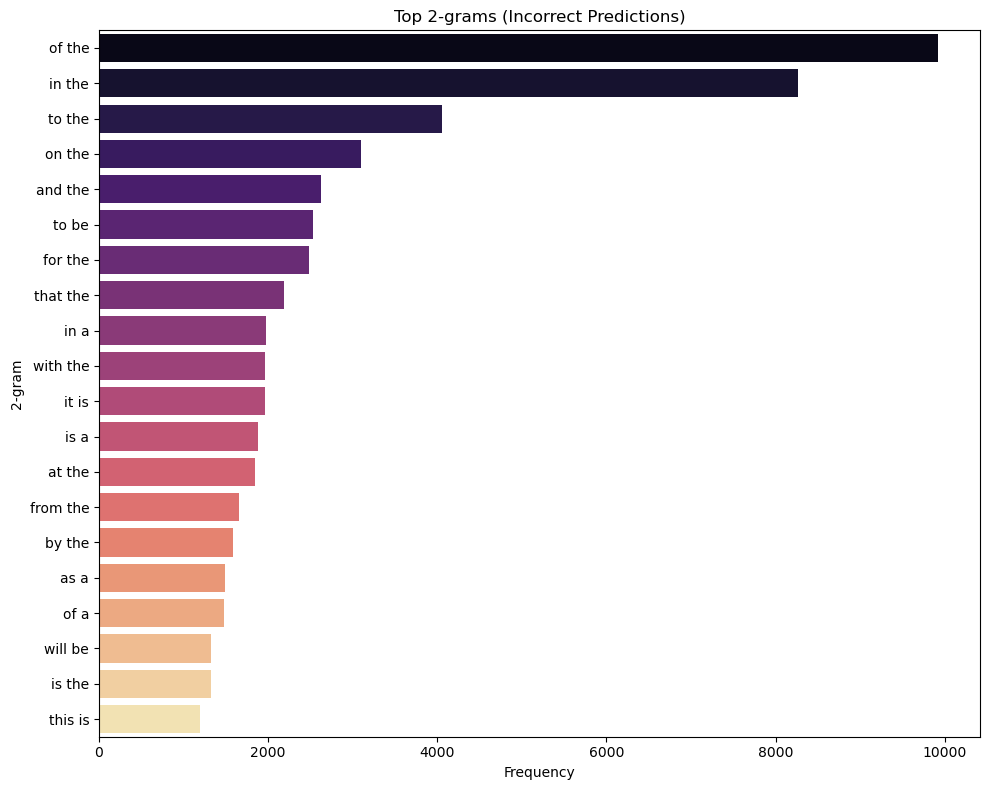


-- Top 3-grams --

Top 3-grams for Correct Predictions:
               3-gram  Frequency
0          one of the       2467
1            a lot of       1963
2   the united states       1915
3          as well as       1601
4         in order to       1246
5          be able to       1237
6       the fact that       1137
7    according to the       1025
8         some of the       1025
9             to be a        883
10        a number of        851
11      the number of        798
12        part of the        774
13         there is a        760
14         out of the        720
15        you want to        715
16         the end of        711
17          this is a        708
18         the use of        689
19       in the world        688


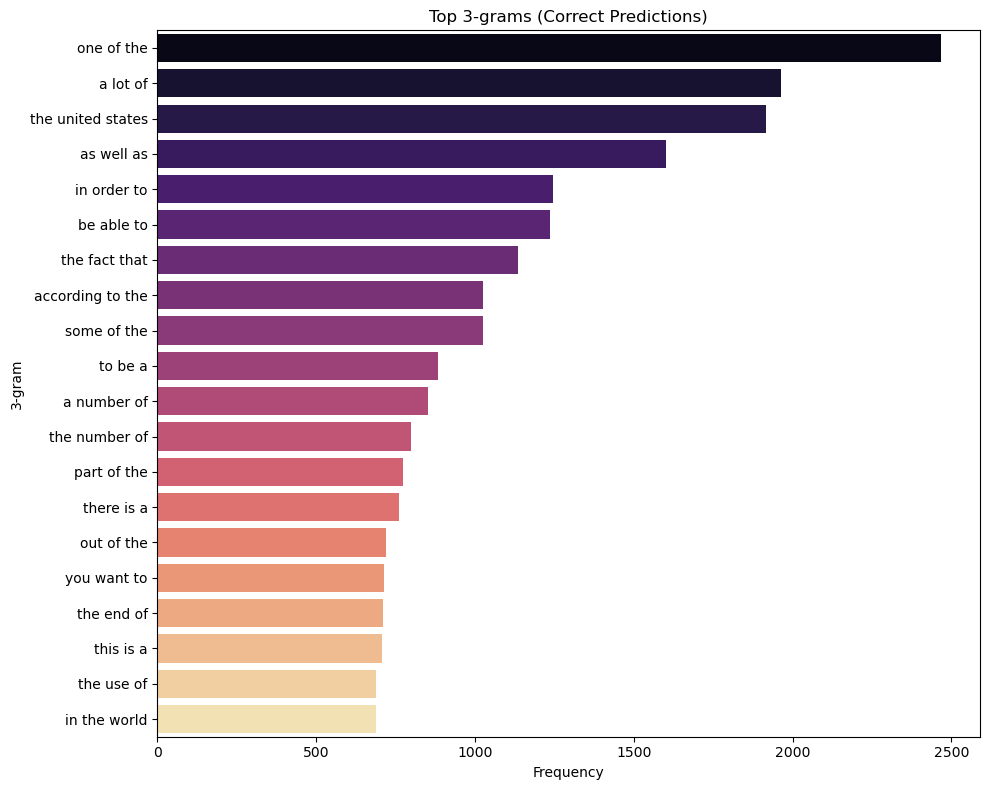


Top 3-grams for Incorrect Predictions:
               3-gram  Frequency
0          one of the        721
1            a lot of        554
2   the united states        485
3          as well as        480
4          be able to        372
5         in order to        347
6         some of the        323
7    according to the        302
8       the fact that        293
9         part of the        280
10        a number of        276
11            to be a        260
12      the number of        243
13         the use of        241
14         the end of        235
15         there is a        235
16          this is a        221
17       in the world        213
18        as a result        212
19      in the united        205


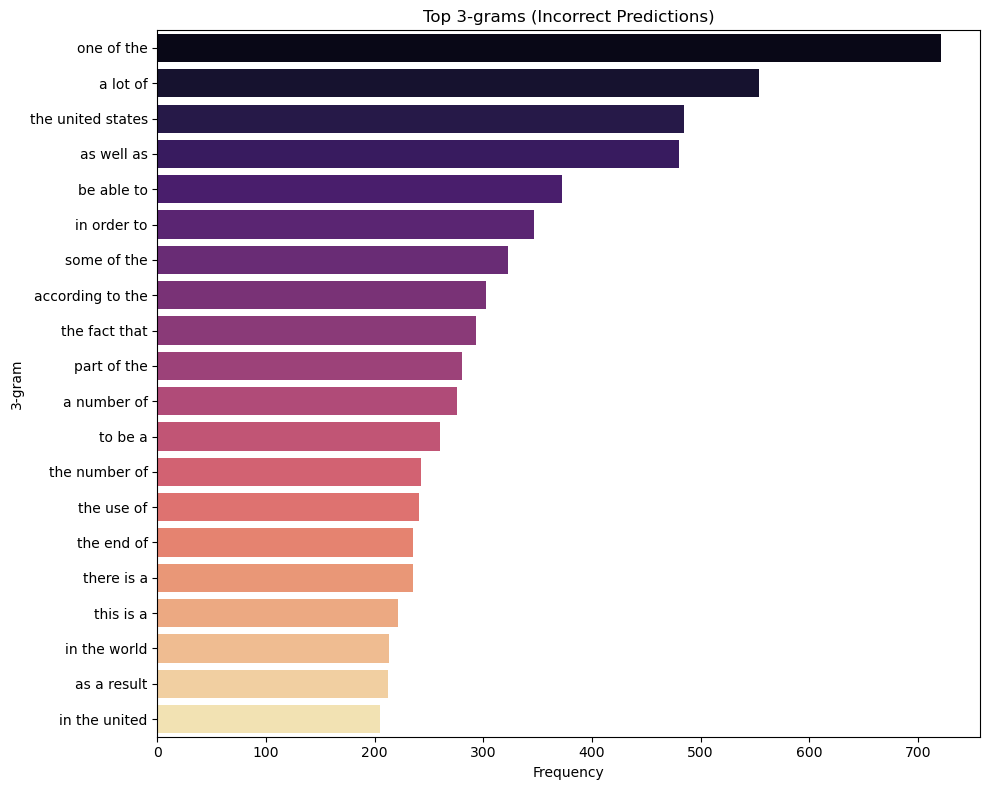

In [20]:
## 4 N-gram Analysis
print("\n--- Analyzing N-grams ---")

def get_top_ngrams(text_series, n=2, num_ngrams=20):
    if len(text_series) == 0:
        return pd.DataFrame(columns=[f'{n}-gram', 'Frequency'])

    # Simple whitespace and punctuation cleaning for n-grams
    def clean_for_ngrams(text):
        text = text.lower()
        text = re.sub(f"[{re.escape(string.punctuation)}]", "", text) # Remove punctuation
        text = re.sub(r'\s+', ' ', text).strip() # Normalize whitespace
        return text

    all_ngrams = []
    cleaned_texts = text_series.apply(clean_for_ngrams)
    for text in cleaned_texts:
        words = text.split()
        if len(words) >= n:
            grams = [" ".join(words[i:i+n]) for i in range(len(words) - n + 1)]
            all_ngrams.extend(grams)

    if not all_ngrams:
        return pd.DataFrame(columns=[f'{n}-gram', 'Frequency'])

    ngram_freq = Counter(all_ngrams)
    common_ngrams = ngram_freq.most_common(num_ngrams)
    return pd.DataFrame(common_ngrams, columns=[f'{n}-gram', 'Frequency'])

def plot_ngrams(df, title, filename):
    if df.empty:
        print(f"Skipping plot for '{title}': No n-grams found.")
        return
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Frequency', y=df.columns[0], data=df, palette='magma')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, filename))
    plt.show()


# Analyze Bigrams (n=2) and Trigrams (n=3)
for n_gram_size in [2, 3]:
    print(f"\n-- Top {n_gram_size}-grams --")

    # Correct
    top_ngrams_correct = get_top_ngrams(correct_df['text'], n=n_gram_size, num_ngrams=20)
    print(f"\nTop {n_gram_size}-grams for Correct Predictions:")
    print(top_ngrams_correct)
    plot_ngrams(top_ngrams_correct, f'Top {n_gram_size}-grams (Correct Predictions)', f"ngram{n_gram_size}_correct.png")

    # Incorrect
    top_ngrams_incorrect = get_top_ngrams(incorrect_df['text'], n=n_gram_size, num_ngrams=20)
    print(f"\nTop {n_gram_size}-grams for Incorrect Predictions:")
    print(top_ngrams_incorrect)
    plot_ngrams(top_ngrams_incorrect, f'Top {n_gram_size}-grams (Incorrect Predictions)', f"ngram{n_gram_size}_incorrect.png")

    # FP / FN
    # top_ngrams_fp = get_top_ngrams(fp_df['text'], n=n_gram_size, num_ngrams=15)
    # plot_ngrams(top_ngrams_fp, f'Top {n_gram_size}-grams (False Positives)', f"ngram{n_gram_size}_fp.png")
    # top_ngrams_fn = get_top_ngrams(fn_df['text'], n=n_gram_size, num_ngrams=15)
    # plot_ngrams(top_ngrams_fn, f'Top {n_gram_size}-grams (False Negatives)', f"ngram{n_gram_size}_fn.png")

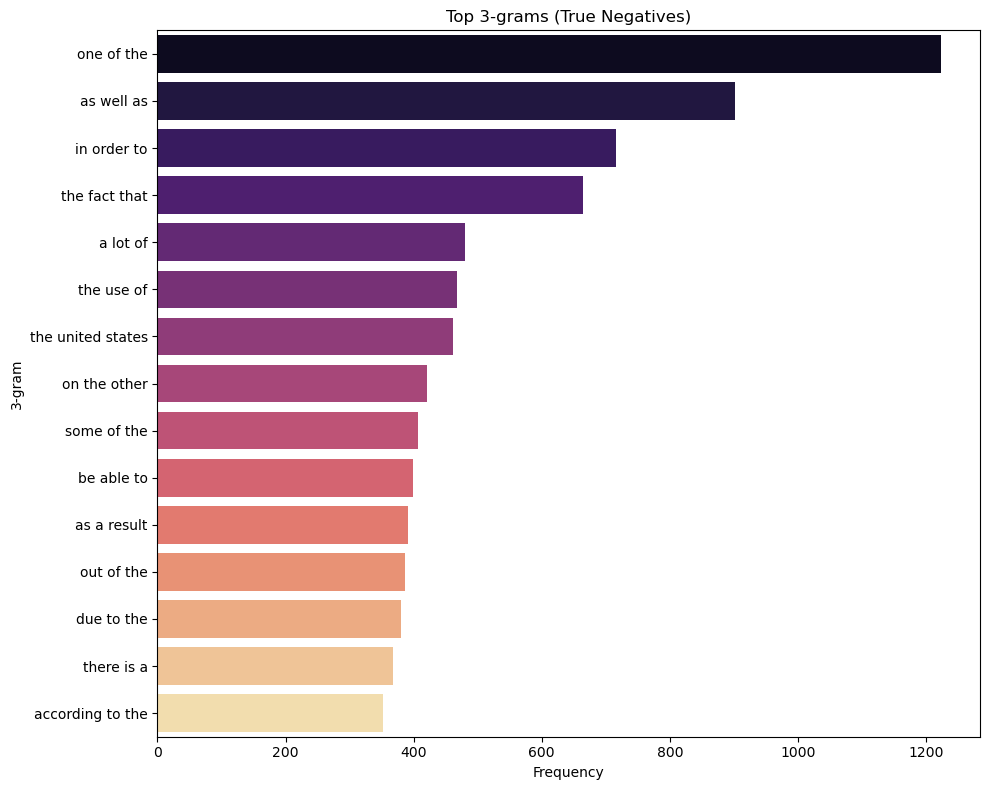

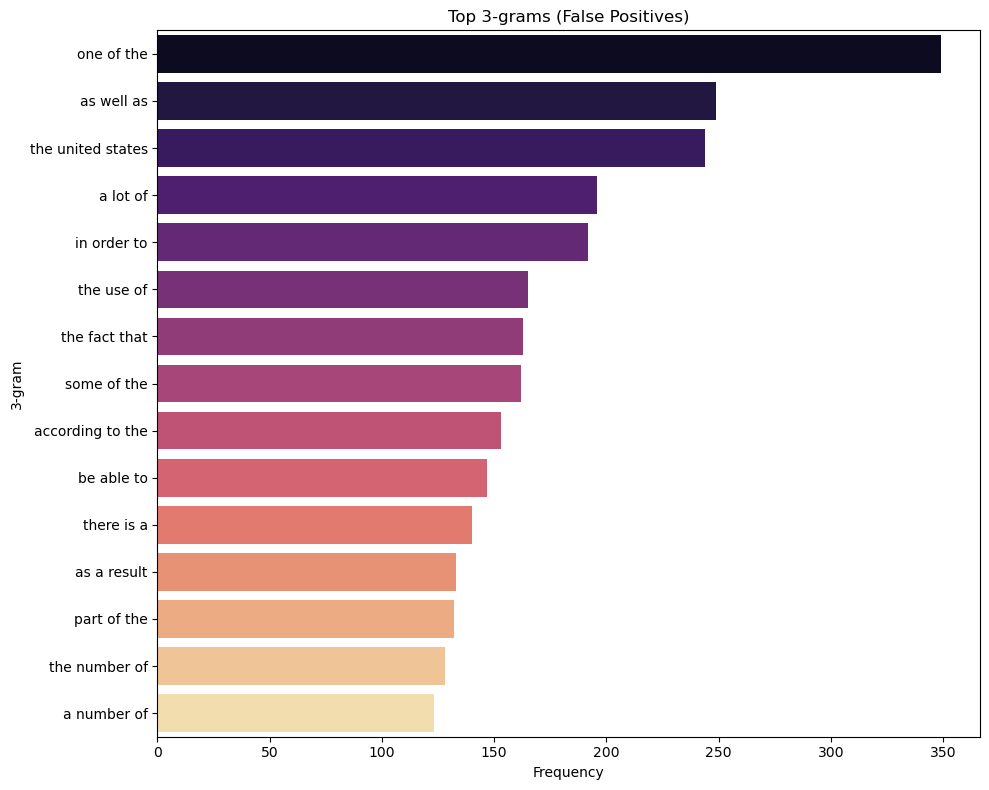

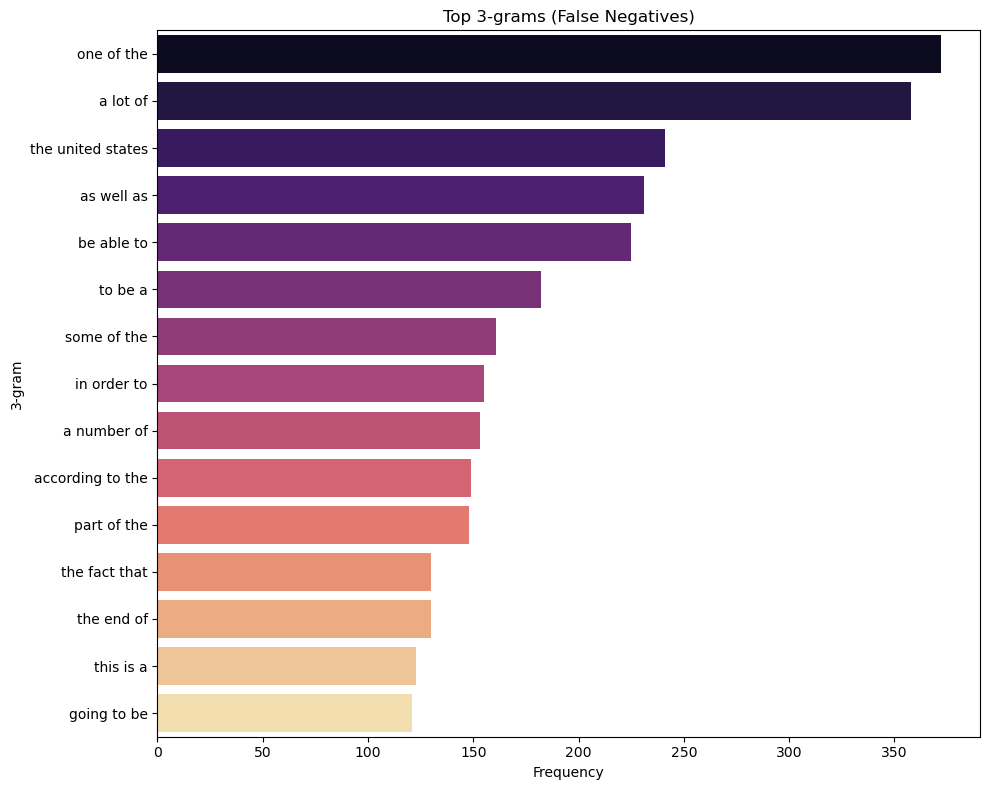

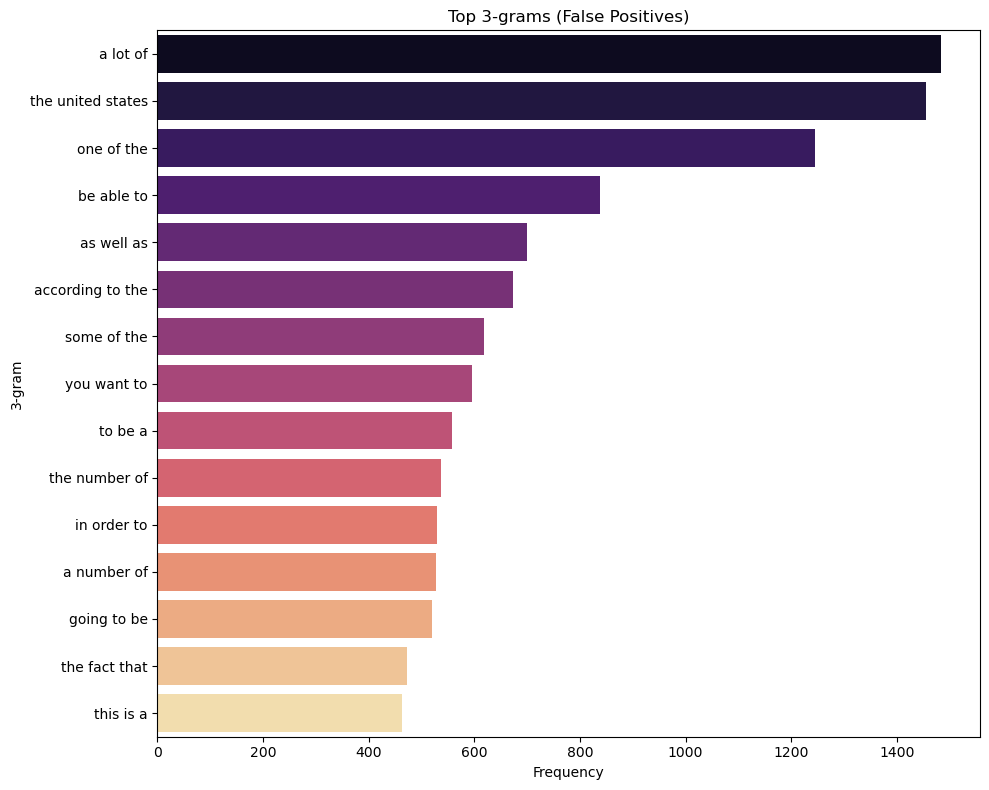

In [21]:
top_ngrams_tn = get_top_ngrams(tn_df['text'], n=n_gram_size, num_ngrams=15)
plot_ngrams(top_ngrams_tn, f'Top {n_gram_size}-grams (True Negatives)', f"ngram{n_gram_size}_tn.png")
top_ngrams_fp = get_top_ngrams(fp_df['text'], n=n_gram_size, num_ngrams=15)
plot_ngrams(top_ngrams_fp, f'Top {n_gram_size}-grams (False Positives)', f"ngram{n_gram_size}_fp.png")
top_ngrams_fn = get_top_ngrams(fn_df['text'], n=n_gram_size, num_ngrams=15)
plot_ngrams(top_ngrams_fn, f'Top {n_gram_size}-grams (False Negatives)', f"ngram{n_gram_size}_fn.png")
top_ngrams_tp = get_top_ngrams(tp_df['text'], n=n_gram_size, num_ngrams=15)
plot_ngrams(top_ngrams_tp, f'Top {n_gram_size}-grams (False Positives)', f"ngram{n_gram_size}_tp.png")

- FP Root Cause (Topic Bias): The model seems biased towards flagging text about news, reporting, information dissemination, and certain common AI-generated topics (like games) as AI-generated, even when written by humans. These human texts (FPs) might lack the typical personal/work narrative keywords found strongly in TNs.

- FN Root Cause (Jargon/Mimicry + Simplicity): The model fails to detect AI when the text uses specialized jargon outside the model's core "AI keyword profile" or when it successfully mimics human interaction patterns (support, casual chat), especially when combined with simpler sentence structures (lower complexity scores).

- Model's AI Profile: The model associates AI (TP) with common words, reporting (said), specific topics (game, government), and expressions of intent/information (want, think, need).

- This complete picture strongly suggests the model uses a combination of topical cues and structural complexity, but it can be misled when these signals conflict or when encountering text outside its typical training distribution patterns (niche human topics flagged as AI, niche AI topics/styles flagged as human).




--- Analyzing Prediction Confidence ---


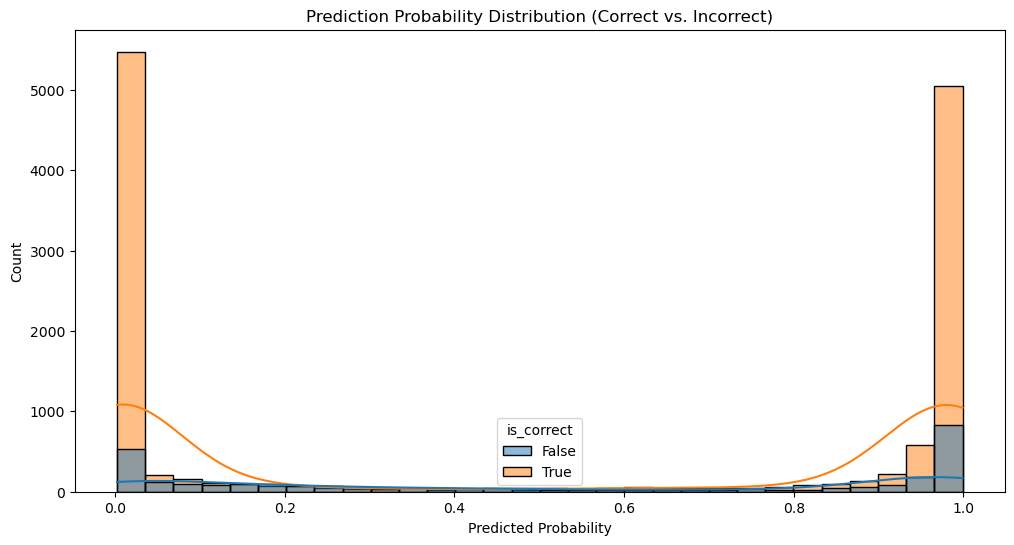


Average Prediction Probability:
is_correct
False    0.523846
True     0.497137
Name: pred_probability, dtype: float32


In [22]:
## 5 Confidence Analysis 
print("\n--- Analyzing Prediction Confidence ---")
plt.figure(figsize=(12, 6))
sns.histplot(data=val_df, x='pred_probability', hue='is_correct', kde=True, bins=30)
plt.title('Prediction Probability Distribution (Correct vs. Incorrect)')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.savefig(os.path.join(OUTPUT_DIR, "confidence_histogram.png"))
plt.show()

print("\nAverage Prediction Probability:")
print(val_df.groupby('is_correct')['pred_probability'].mean())

**Implications:**
- Overconfidence in Errors: This suggests the model might be latching onto certain features or patterns that strongly (but incorrectly) indicate one class over the other in specific cases.

- Calibration: The model might be poorly calibrated, meaning its predicted probabilities don't accurately reflect the true likelihood of correctness. Ideally, predictions made with ~80% confidence should be correct about 80% of the time, which isn't happening for the incorrect group.

- Difficulty of Errors: The errors the model makes aren't necessarily "borderline" cases from its perspective. It often makes a mistake with conviction.


--- Analyzing Prediction Confidence by result type ---


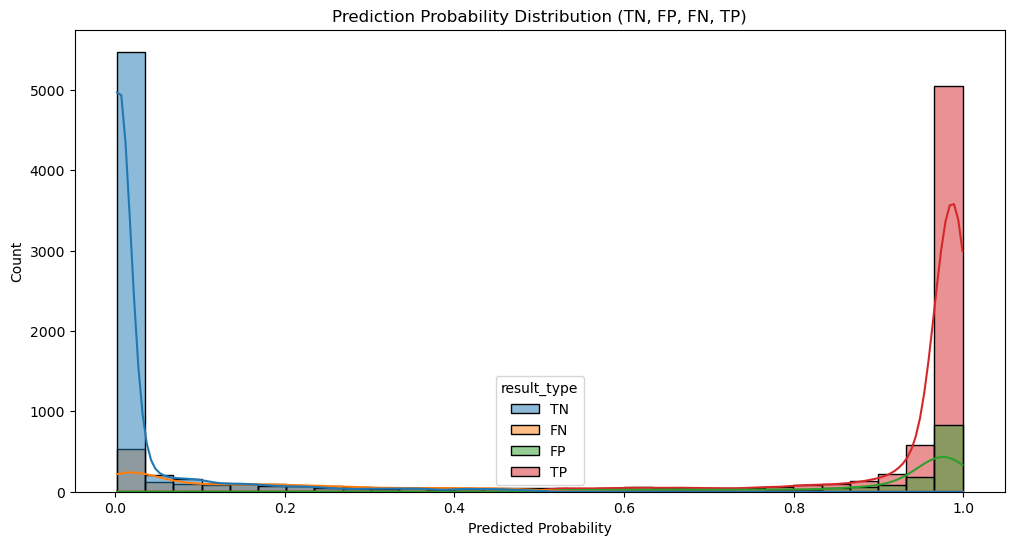


Average Prediction Probability:
result_type
FN    0.145806
FP    0.914149
TN    0.031830
TP    0.954178
Name: pred_probability, dtype: float32


In [23]:
print("\n--- Analyzing Prediction Confidence by result type ---")
plt.figure(figsize=(12, 6))
sns.histplot(data=val_df, x='pred_probability', hue='result_type', kde=True, bins=30)
plt.title('Prediction Probability Distribution (TN, FP, FN, TP)')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.savefig(os.path.join(OUTPUT_DIR, "confidence_histogram_by_type.png"))
plt.show()

print("\nAverage Prediction Probability:")
print(val_df.groupby('result_type')['pred_probability'].mean())

In [24]:
# --- 5.1 Analysis of High-Confidence Errors ---
print("\n--- Analyzing High-Confidence Errors ---")

# Define the confidence threshold
confidence_threshold = 0.90 

text_col = 'text'
true_label_col = 'label' 
pred_label_col = 'prediction' 
prob_col = 'pred_probability' 
correct_col = 'is_correct'

# Filter for incorrect predictions with high confidence
high_confidence_errors_df = val_df[
    (val_df[correct_col] == False) &
    (val_df[prob_col] > confidence_threshold)
].copy() 

# Sort by probability to see the most confident errors first
high_confidence_errors_df = high_confidence_errors_df.sort_values(by=prob_col, ascending=False)

print(f"Found {len(high_confidence_errors_df)} examples where the prediction was incorrect")
print(f"but the model's confidence in the wrong prediction was > {confidence_threshold:.2f}")

# --- Displaying Examples ---

# Display the top N most confident errors
num_examples_to_show = 10 

print(f"\n--- Top {num_examples_to_show} Most Confident Errors ---")

if len(high_confidence_errors_df) > 0:
    display_cols = [text_col, true_label_col, pred_label_col, prob_col]
    
    display_cols = [col for col in display_cols if col in high_confidence_errors_df.columns]

    for index, row in high_confidence_errors_df.head(num_examples_to_show).iterrows():
        print(f"\n--- Example Index: {index} ---")
        print(f"  True Label:       {row[true_label_col]}")
        print(f"  Predicted Label:  {row[pred_label_col]}")
        print(f"  Confidence (Wrong): {row[prob_col]:.4f}")
        # Print the first 500 characters of the text for brevity
        print(f"  Text Snippet:     {row[text_col][:500]}...") 
        print("-" * 30)
else:
    print("No high-confidence errors found matching the criteria.")

# --- Saving Examples ---

if len(high_confidence_errors_df) > 0 and 'OUTPUT_DIR' in locals():
    try:
        output_filename = os.path.join(OUTPUT_DIR, f"high_confidence_errors_gt_{confidence_threshold:.2f}.csv")
        # Save to a CSV
        high_confidence_errors_df.to_csv(output_filename, index=False)
        print(f"\nSaved all {len(high_confidence_errors_df)} high-confidence error examples to: {output_filename}")
    except Exception as e:
        print(f"\nCould not save high-confidence errors to CSV: {e}")



--- Analyzing High-Confidence Errors ---
Found 1103 examples where the prediction was incorrect
but the model's confidence in the wrong prediction was > 0.90

--- Top 10 Most Confident Errors ---

--- Example Index: 14373 ---
  True Label:       0
  Predicted Label:  1
  Confidence (Wrong): 0.9989
  Text Snippet:     what is cannabis cannabis also known as marijuana is a plant the dried leaves flowering parts or resin extracted from the plant can be taken recreationally mostly to invoke feelings of sociability happiness or relaxation the main component of cannabis that causes these effects is called thc which stands for tetrahydrocannabinol there are some existing medical uses for cannabis including to relieve certain types of pain and to treat symptoms of nausea that can come as part of chemotherapy how doe...
------------------------------

--- Example Index: 14554 ---
  True Label:       0
  Predicted Label:  1
  Confidence (Wrong): 0.9988
  Text Snippet:     cellulitis is a skin i

In [25]:
# ## 6 Word Clouds (Visual Keyword Summary)
# print("\n--- Generating Word Clouds ---")

# def generate_wordcloud(text_series, title, filename):
#     if len(text_series) == 0 or text_series.str.len().sum() == 0:
#         print(f"Skipping word cloud for '{title}': No text data.")
#         return

#     text = ' '.join(text_series.astype(str))
#     wordcloud = WordCloud(
#         stopwords=stop_words,
#         background_color='white',
#         max_words=100,
#         width=800, height=400
#         # max_font_size=50,
#         # scale=2,
#         # random_state=42
#     ).generate(text)

#     plt.figure(figsize=(12, 6))
#     plt.imshow(wordcloud, interpolation='bilinear')
#     plt.axis('off')
#     plt.title(title)
#     plt.savefig(os.path.join(OUTPUT_DIR, filename))
#     plt.show()

# generate_wordcloud(correct_df['text'], 'Word Cloud (Correct Predictions)', 'wordcloud_correct.png')
# generate_wordcloud(incorrect_df['text'], 'Word Cloud (Incorrect Predictions)', 'wordcloud_incorrect.png')
# # generate_wordcloud(fp_df['text'], 'Word Cloud (False Positives)', 'wordcloud_fp.png')
# # generate_wordcloud(fn_df['text'], 'Word Cloud (False Negatives)', 'wordcloud_fn.png')